# 16-6. 프로젝트 - Movielens 영화 SBR

## Step 0. 환경설정 및 라이브러리 Import

In [1]:
# 1) 데이터 확인
! ls -l ~/data

# 2) 프로젝트 폴더 생성
! mkdir -p ~/aiffel/yoochoose

# 3) 프로젝트 폴더로 데이터 폴더 링크 연결
# ! ln -s ~/data/* ~/aiffel/yoochoose/data

total 1893592
-rwxrwxrwx 1 root root       3973 Dec 21  2021 dataset-README.txt
-rwxrwxrwx 1 root root     171308 Dec 21  2021 movies.dat
-rwxrwxrwx 1 root root   24594131 Dec 21  2021 ratings.dat
-rwxrwxrwx 1 root root       5577 Dec 21  2021 README
drwxr-xr-x 5 root root       4096 Feb 23  2022 trained_model
-rwxrwxrwx 1 root root     134368 Dec 21  2021 users.dat
-rwxrwxrwx 1 root root   55583744 Dec 21  2021 yoochoose-buys.dat
-rwxrwxrwx 1 root root 1486798186 Dec 21  2021 yoochoose-clicks.dat
-rwxrwxrwx 1 root root  371725851 Dec 21  2021 yoochoose-test.dat


In [2]:
import os
from pathlib import Path
import datetime as dt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', 
                       header=None, usecols=[0, 1, 2, 3], 
                       dtype={0: np.int32, 1: np.int32, 2: np.int32}, 
                       nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 1. 데이터의 전처리

### 1-1. 항목별 기본 분석

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### 6,040명의 User와 3,706편의 영화 Item이 있습니다.

In [5]:
data['Rating'].min(), data['Rating'].max()

(1, 5)

#### Rating은 최소 1점부터 최대 5점까지 있습니다.

In [6]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

#### 2000년 4월 25일부터 2003년 2월 28일까지 약 2년 10개월치의 데이터가 있습니다.

### 1-2. Session Length

#### 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있으므로 UserID가 SessionID 역할을 하도록 합니다.

In [7]:
# UserId를 SessionId 대신 사용함.
User_length = data.groupby('UserId').size()
User_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
User_length.median(), User_length.mean()

(96.0, 165.5975165562914)

#### 한 User당 평균 165편의 영화를 평가했습니다.

In [9]:
User_length.min(), User_length.max()

(20, 2314)

#### 가장 적은수의 평가를 한 User는 20편을 평가했고 가장 많은수의 평가를 한 User는 2314편을 평가했습니다.

In [10]:
Item_length = data.groupby('ItemId').size()
Item_length.min(), Item_length.max()

(1, 3428)

#### 가장 적은수의 평가를 받은 영화는 1번을 평가받았고 가장 많은수의 평가를 받은 영화는 3,428번을 평가 받았습니다.

In [11]:
User_length.quantile(0.999)

1343.181000000005

#### 평가 수가 가장 적은 User로부터 총 평가 수의 99.9%에 이를때까지 각 User의 평가 수를 누적했을 때
#### 포함된 마지막 User의 평가 수는 1,343편 입니다.

In [12]:
long_session = User_length[User_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


#### 가장 많은 영화를 평가한 User는 ID가 4169번이며 2000. 08. 03 ~ 2002. 06. 15까지 2314편을 평가하였습니다.

In [13]:
length_count = User_length.groupby(User_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

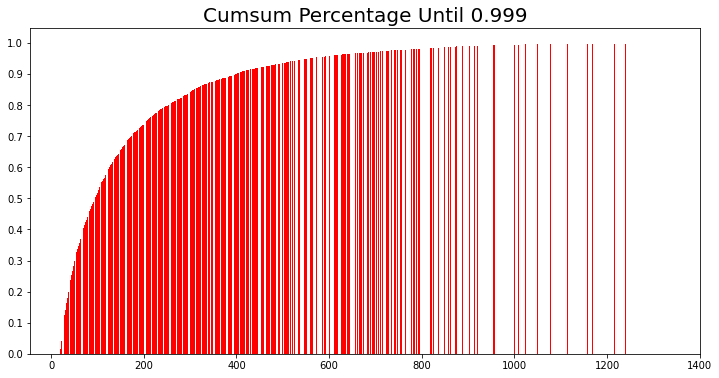

In [14]:
plt.figure(figsize=(12, 6))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks([0, 200, 400, 600, 800, 1000, 1200, 1400])
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1.3 Session Time

In [15]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


#### 2000년 4월 25일부터 2003년 2월 28일까지 약 2년 10개월치의 데이터가 있습니다.
#### 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요하다고 생각되어 최근 1년치의
#### 데이터를 사용해 보았으나 전저리 등을 하면 454 User, 1,245편으로 줄어 학습이 제대로 이루어지지
#### 않았습니다. 그래서 3년치 데이터를 모두 사용하겠습니다.

In [16]:
# year_ago = latest - dt.timedelta(365)  # 최종 날짜로부터 365일 이전 날짜를 구한다.  
# data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

### 1.4 Data Cleansing

In [17]:
# 추천에 사용할 데이터이므로 평점 3점 이상만 남깁니다.
orginal_data_size = len(data)

data = data[data['Rating']>=3]
filtered_data_size = len(data)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


#### 평점 3점 이상인 데이터는전체 데이터의 83.63%로 학습에 무리없는 수준으로 판단됩니다.

In [18]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

#### 6,040명, 3,706편에서 6,039명, 3,628편으로 1명, 78편이 줄었습니다.

#### 가장 적은수의 영화를 평가한 User의 평가수는 20이므로  문제가 없어보이나 1번만 평가받은 영화가 
#### 있으므로 5번 미만의 평가를 받은 인기없는 영화는 제거하겠습니다. 이 과정에서 1번만 평가한 User가 
#### 발생할 수 있으므로 이런경우 해당 User도 제거하겠습니다.

In [19]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [20]:
data = cleanse_recursive(data, shortest=4, least_click=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [21]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6038, 3509)

#### 총 6,040 User,  3,706편에서 전처리 과정에서 6,038 User, 3,307편으로 줄었습니다.

### 1.5 Train / Valid / Test split

In [22]:
def split_by_date(data: pd.DataFrame, days_val,days_test: int):
    final_time = data['Time'].max()
    data_tr = data[data['Time'] < final_time - dt.timedelta(days_val+days_test)]
    data_remain = data[data['Time'] >= final_time - dt.timedelta(days_val+days_test)]
    data_val = data_remain[data_remain['Time'] < final_time - dt.timedelta(days_test)] 
    data_test = data_remain[data_remain['Time'] >= final_time - dt.timedelta(days_test)]

    return data_tr, data_val, data_test

#### 전체 데이터 중 150일치는 Validation용으로, 150일치는 Test용으로 사용하겠습니다.

In [23]:
tr, val, test = split_by_date(data, days_val=150, days_test=150)

In [24]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Status Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [25]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Status Info
	 Events: 823236
	 Users: 6037
	 Items: 3509
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-05-04 09:26:12

* valid Set Status Info
	 Events: 6906
	 Users: 326
	 Items: 2075
	 First Time : 2002-05-04 21:11:01
	 Last Time : 2002-10-01 09:36:33

* test Set Status Info
	 Events: 6216
	 Users: 310
	 Items: 1915
	 First Time : 2002-10-01 19:26:51
	 Last Time : 2003-02-28 17:49:50



In [26]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [27]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

### 2.1 SessionDataset

In [28]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [29]:
tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,1104
999988,6040,1921,4,2001-08-10 14:41:04,315
1000172,6040,1784,3,2001-08-10 14:41:04,87
1000167,6040,161,3,2001-08-10 14:41:26,410


In [30]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 822841, 822960, 823236], dtype=int32)

In [31]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6034, 6035, 6036])

### 2.2 SessionDataLoader

In [32]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)  # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1        # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]    # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])  # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False    # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len  # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]  # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [33]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,1104
999988,6040,1921,4,2001-08-10 14:41:04,315
1000172,6040,1784,3,2001-08-10 14:41:04,87
1000167,6040,161,3,2001-08-10 14:41:26,410


In [34]:
iter_ex = iter(tr_data_loader)

In [35]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

### 3.1 Evaluation Metric

In [36]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 3.2 Model Architecture

In [37]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    return model

In [38]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [39]:
args = Args(tr, val, test, batch_size=1024, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1024, 1, 3509)]         0         
_________________________________________________________________
GRU (GRU)                    [(1024, 50), (1024, 50)]  534150    
_________________________________________________________________
dropout (Dropout)            (1024, 50)                0         
_________________________________________________________________
dense (Dense)                (1024, 3509)              178959    
Total params: 713,109
Trainable params: 713,109
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습 및 테스트

In [40]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다.
                                              # 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')      # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서 parameter를 초기화 합니다.
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, 
                                    total=total_step // args.batch_size, 
                                    desc='Evaluation', 
                                    mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [41]:
# 모델 테스트 함수
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [42]:
args = Args(tr, val, test, batch_size=64, hsz=150, drop_rate=0.2, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Evaluation:  69%|██████▊   | 70/102 [00:20<00:09,  3.34it/s]


	 - Recall@20 epoch 1: 0.113170
	 - MRR@20    epoch 1: 0.032166



Evaluation:  69%|██████▊   | 70/102 [00:20<00:09,  3.42it/s]


	 - Recall@20 epoch 2: 0.125446
	 - MRR@20    epoch 2: 0.037052



Evaluation:  69%|██████▊   | 70/102 [00:20<00:09,  3.41it/s]


	 - Recall@20 epoch 3: 0.129464
	 - MRR@20    epoch 3: 0.038699



Evaluation:  69%|██████▊   | 70/102 [00:20<00:09,  3.44it/s]


	 - Recall@20 epoch 4: 0.131920
	 - MRR@20    epoch 4: 0.039334



Evaluation:  69%|██████▊   | 70/102 [00:20<00:09,  3.42it/s]


	 - Recall@20 epoch 5: 0.136161
	 - MRR@20    epoch 5: 0.040449



Evaluation:  55%|█████▌    | 51/92 [00:14<00:11,  3.46it/s]

	 - Recall@20: 0.170037
	 - MRR@20: 0.051165



#### Epoch가 진행됨에 따라 loss가 5.59에서 5.16으로 감소, Recall은 0.116에서 0.131로, MRR은 0.032에서 0.040으로 개선되었다.
#### Test Recall은 0.170, Test MRR은 0.051로 Train시 보다 더 좋은값을 보여준다.

## 1. Batch Size 조정

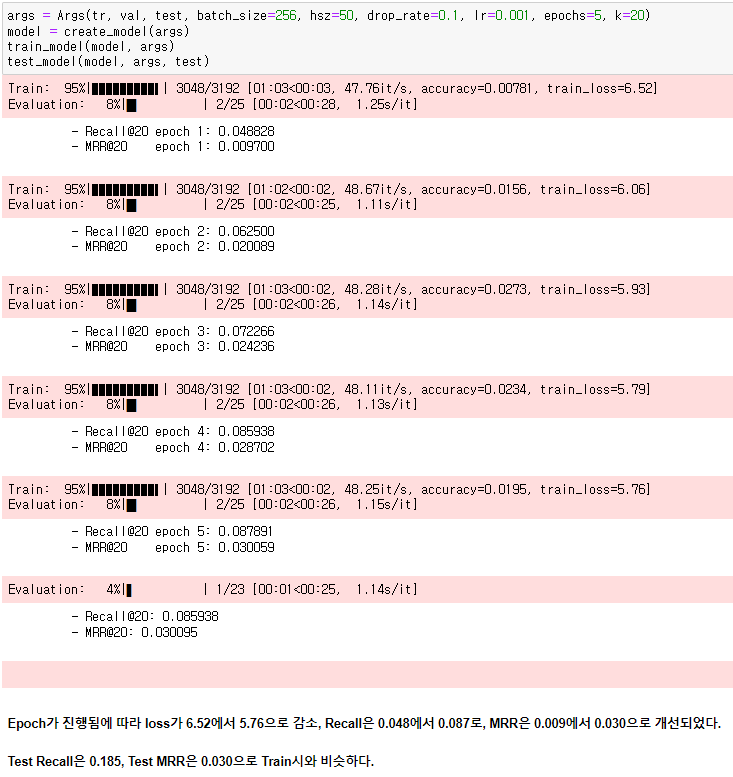

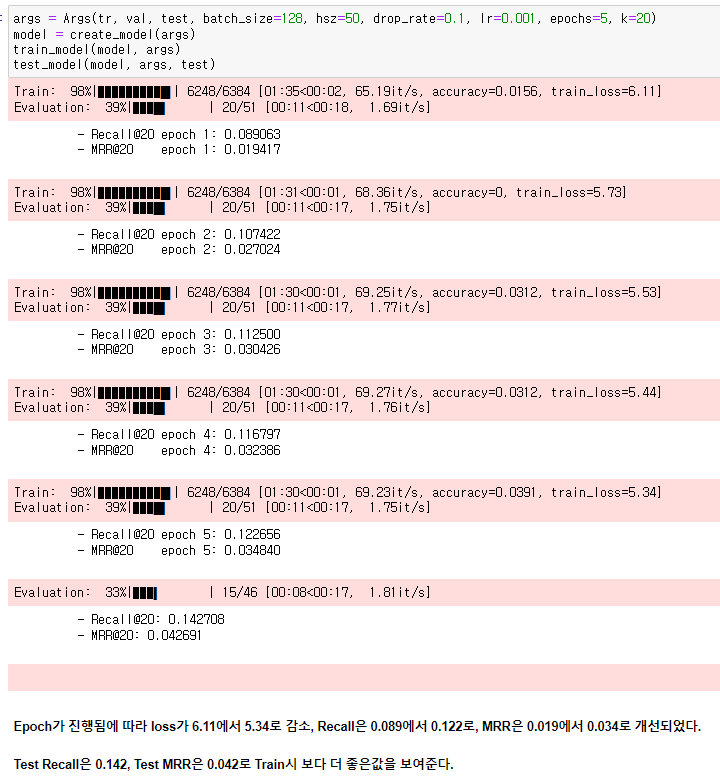

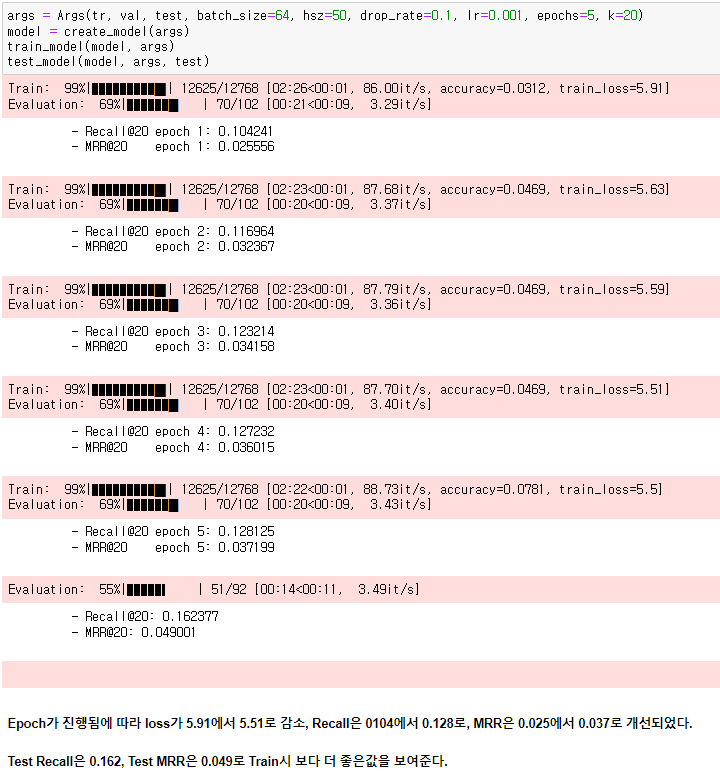

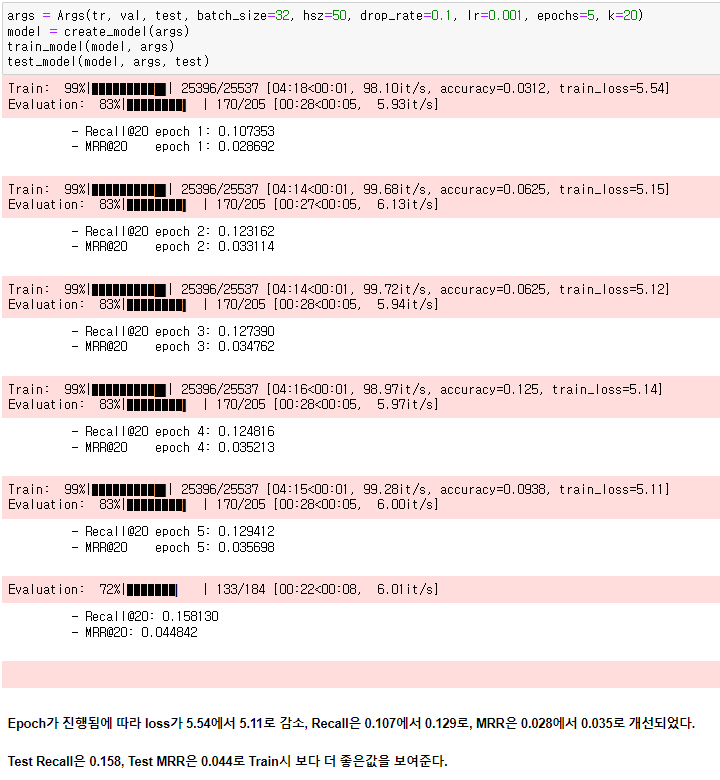

#### Batch Size를 변경해본 결과 Batch size가 줄어듦에 따라 Model 성능이 좋아지다가 32에서는 나빠졌다.

## 2. hsz 조정

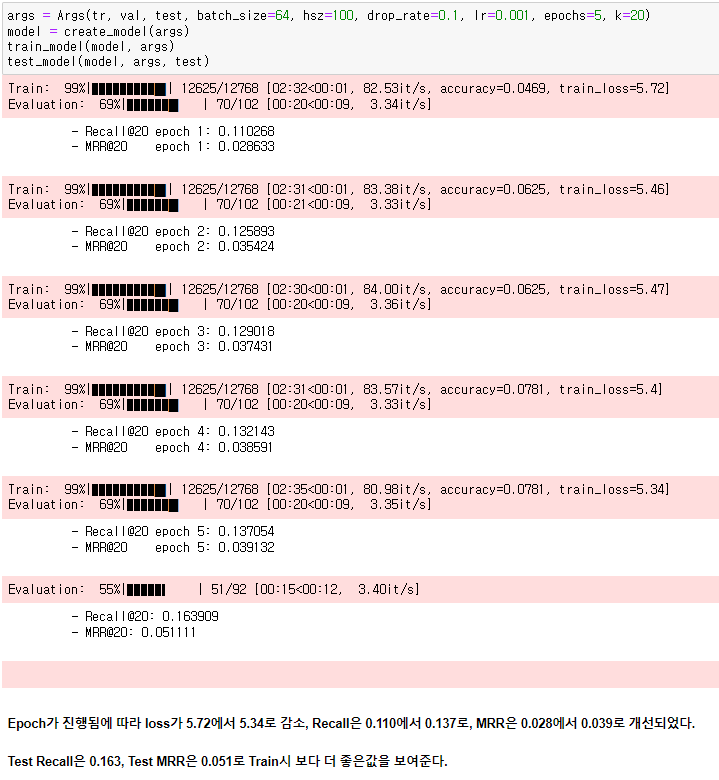

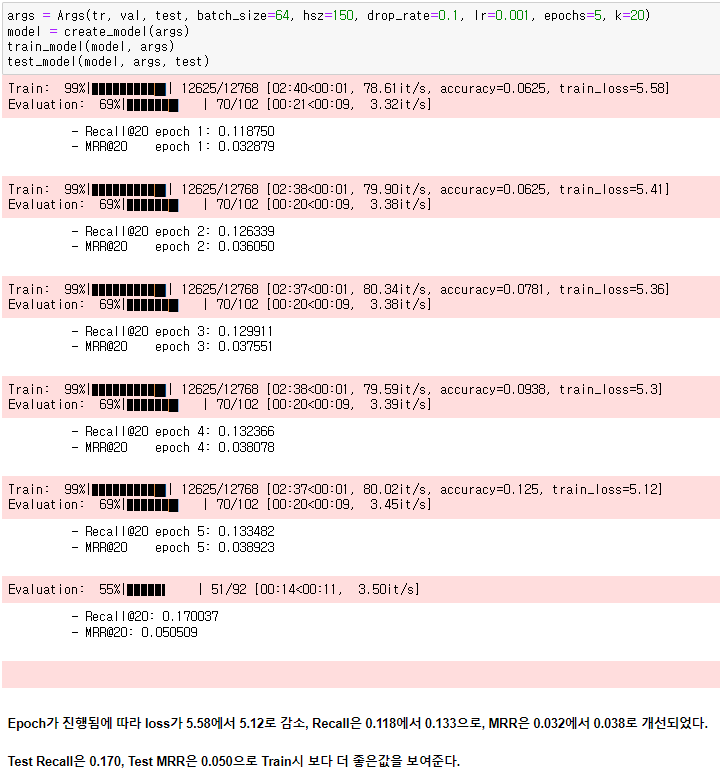

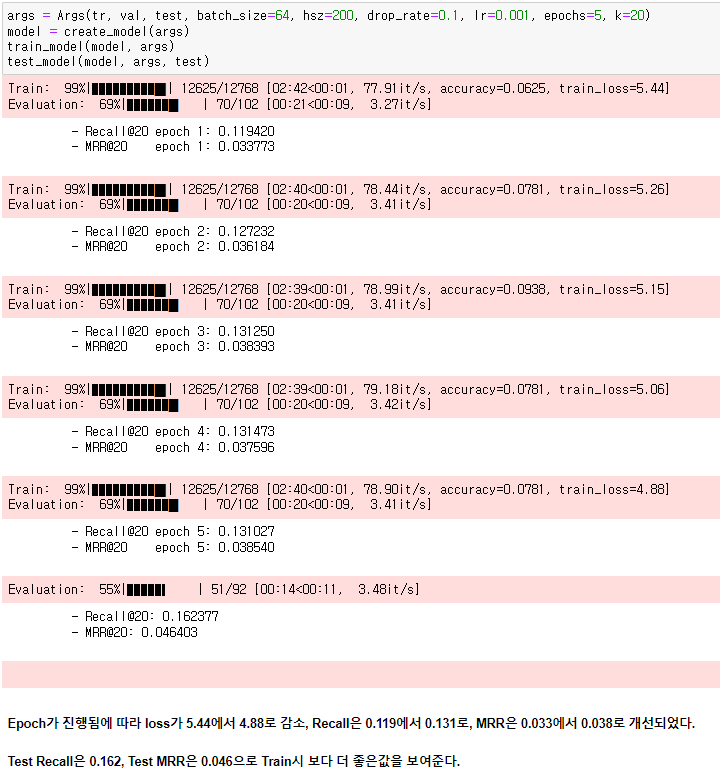

#### hsz 150에서 가장 좋은 성능을 나타낸다.

## 3. Drop rate 조정

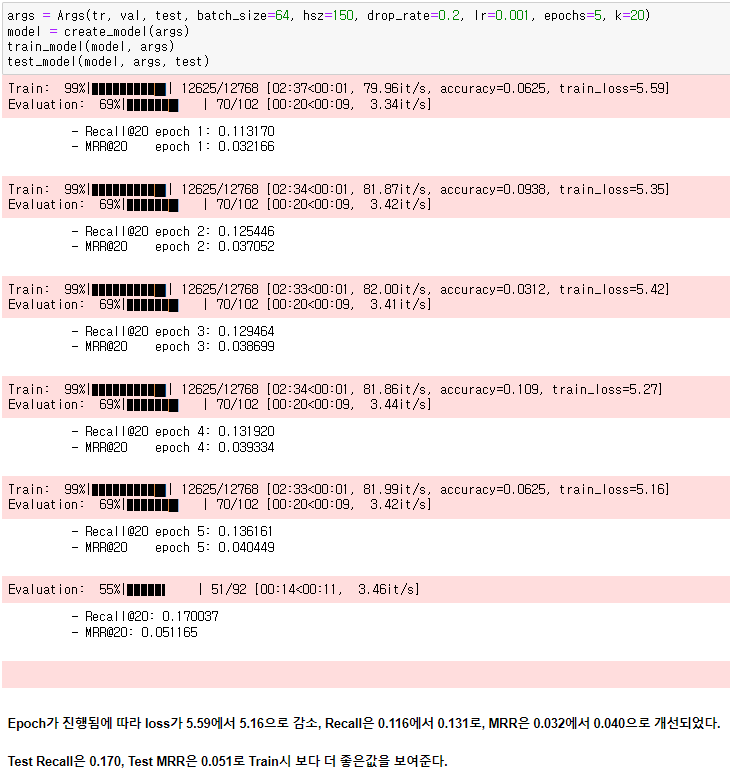

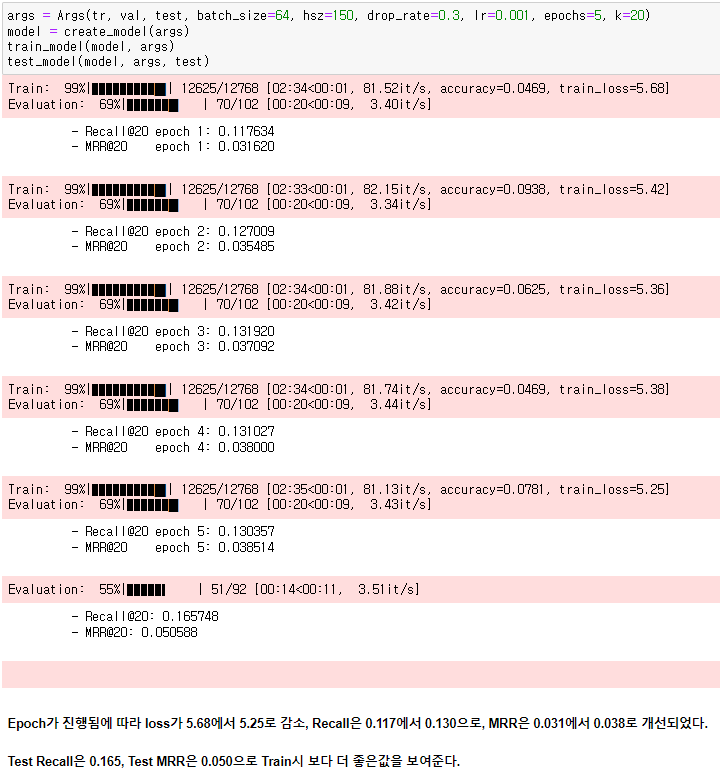

#### Drop rate 0.2에서 가장 좋은 성능을 나타낸다.

## 4. k값 조정

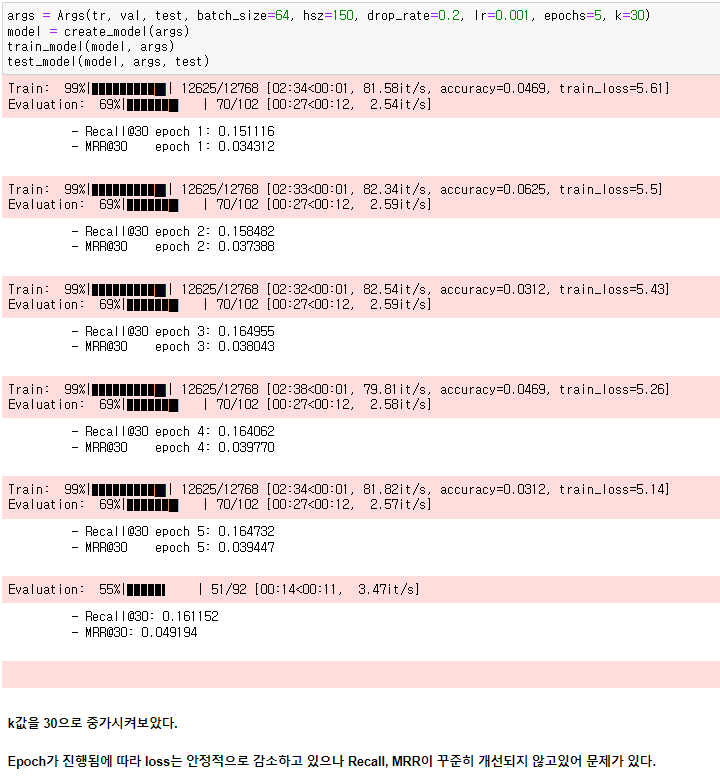

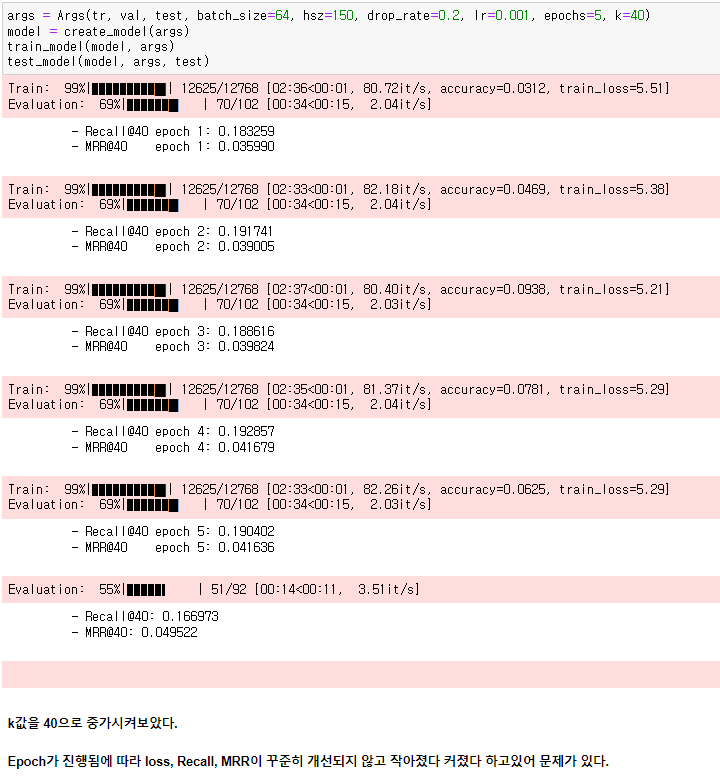

#### k값 20에서 가장 좋은 성능을 나타낸다.

## 5. 결론

#### Batch size 64, hsz 150, Drop rate 0.2, k 20에서 가장 좋은 성능을 나타냈다. 물론 모든 조합을 test하지 않았기 때문에 
#### 완벽하지는 않지만 어느정도 좋은 조합일것이라고 생각된다.


## 회고
### 이번 프로젝트에서 어려웠던 점

training/validation 과정에서 index error가 발생하였는데 원인을 찾을수가 없어서 고생했다. 그러다가 data split days값을 변경해 보다가 error가 발생하지 않는 경우를 찾게되었다. 이 상태에서도 batch size에 따라 error가 발생할 때가 있고 발생하지 않을때가 있다.

### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

위 error의 원인이 아마도 indexing 부분에 있지 않을까 생각되는데 정확한 이유를 모르겠다.

### 루브릭 평가 지표를 맞추기 위해 시도한 것들

하이퍼 파라미터를 여러 조합으로 변경하여 loss, recall 및 mrr이 개선되는것을 확인 하였다.

### 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

어느정도 달성했다고 생각된다.

### 자기 다짐

Exploration 마지막 과제를 마쳤다. 지금까지 과제 제출하느라 무척 힘들었다. Going Deeper도 열심히 해보자.